# Exploratory Data Analysis for NFL Win Probability Model

## Introduction


# Data Preparation

## Analyzing the Reference Calibration Data

The first step to building the win probability model is to analyze the reference calibration data.  This will be used as a reference that can validate the efficacy of the calibration codebase.  The following test cases are currently supported:

1. Test that the calibration data has the correct number of rows and columns.
2. Test that the calibration data has the correct column names.
3. Test that the calibration data has the correct data types.
4. Test that the calibration data has the correct number of missing values.

The slightest mistake in the calibration logic can taint the dataset, so the tests are managed and run using pytest in `tests/validation/test_calibration.py`.

### Import Reference Calibration Data

The Reference calibration data can be found [here](https://raw.githubusercontent.com/guga31bb/metrics/master/wp_tuning/cal_data.rds).  To validate the data, I will save it as a CSV, and then generate the test calibration data and save that to a CSV as well:

In [1]:
from utils.data_utils import REFERENCE_CAL_DATA_URL, import_rds, save_to_csv

REFERENCE_CAL_DATA_RDS_PATH = 'tests/validation/calibration_data/cal_data.rds'
REFERENCE_CAL_DATA_CSV_PATH = 'tests/validation/calibration_data/reference_cal_data.csv'
CAL_DATA_PATH = 'tests/validation/calibration_data/cal_data.csv'

reference_cal_data = import_rds(REFERENCE_CAL_DATA_URL, REFERENCE_CAL_DATA_RDS_PATH)

# save reference calibration data to CSV
save_to_csv(reference_cal_data, REFERENCE_CAL_DATA_CSV_PATH)

### Generate Test Calibration Data

In [19]:
# Auto reloads updated modules
%load_ext autoreload
%autoreload 2

In [23]:
from utils.data_utils import import_pbp_data
from utils.calibration import create_wp_calibration_data

# import PBP data
start =1999
end = 2023

pbp_data = import_pbp_data(start, end)
cal_data = create_wp_calibration_data(pbp_data)


dtypes = reference_cal_data.dtypes.to_dict()
cal_data = cal_data.astype(dtypes)

# create test calibration data that matches reference calibration data set
ref_start = reference_cal_data['season'].min()
ref_end = reference_cal_data['season'].max()
test_cal_data = cal_data.loc[(cal_data['season'] >= ref_start) & (cal_data['season'] <= ref_end)]

# save test calibration data to CSV
save_to_csv(test_cal_data, CAL_DATA_PATH)
source_cal_data = cal_data.copy()

Downcasting floats.


### Validate the Calibration Data

In [3]:
!source ~/.virtualenvs/nfl-data-models/bin/activate && pytest tests/validation/test_calibration_data.py -v

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.0.0, pluggy-1.3.0 -- /home/dev/.virtualenvs/nfl-data-models/bin/python
cachedir: .pytest_cache
rootdir: /mnt/c/Users/Jonathan Bailey/PycharmProjects/nfl-data-models
configfile: setup.cfg
plugins: anyio-4.0.0, dash-2.14.2
collected 4 items                                                              

tests/validation/test_calibration_data.py::TestWPCalDataValidation::test_compare_column_types_to_reference PASSED [ 25%]
tests/validation/test_calibration_data.py::TestWPCalDataValidation::test_compare_columns_to_reference PASSED [ 50%]
tests/validation/test_calibration_data.py::TestWPCalDataValidation::test_compare_missing_values_in_each_column_to_reference PASSED [ 75%]
tests/validation/test_calibration_data.py::TestWPCalDataValidation::test_compare_shape_to_reference PASSED [100%]

============================== 4 passed in 3.65s ===============================


As soon as the validation passes, we can now use `cal_data` (it contains complete, current calibration data from 1999-2023) to build the win probability model in the next step.

### Preprocessing the Calibration Data

Additional preprocessing is done:
1. make_model_mutations: This function creates new features and modifies existing ones to better suit the model.
2. prepare_wp_data: This function prepares the data for the win probability model by filtering out irrelevant columns and renaming the remaining ones.
3. add_label_column: This function adds a label column to the data, indicating whether the home team won or lost.
4. drop_rows: This function drops rows with missing values, ties, and non regular time periods (ie overtime).
5. Filter columns to only include those relevant to the win probability model.

In [26]:
from utils.calibration import (
    make_model_mutations,
    prepare_wp_data,
    add_label_column,
    drop_rows
)

cal_data = make_model_mutations(source_cal_data)
cal_data = prepare_wp_data(cal_data)
cal_data = add_label_column(cal_data)
cal_data = drop_rows(cal_data)
cal_data = cal_data.loc[cal_data['Winner'] != 'TIE']

WP_CAL_DATA_COLS = ['game_id', 'label', 'receive_2h_ko', 'spread_time', 'home', 'half_seconds_remaining', 'game_seconds_remaining', 'Diff_Time_Ratio', 'score_differential', 'down', 'ydstogo', 'yardline_100', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'season']
cal_data = cal_data[WP_CAL_DATA_COLS]

cal_data.head()

,game_id,label,receive_2h_ko,spread_time,home,half_seconds_remaining,game_seconds_remaining,Diff_Time_Ratio,score_differential,down,ydstogo,yardline_100,posteam_timeouts_remaining,defteam_timeouts_remaining,season
1,1999_01_ARI_PHI,0,0,-3.0,1,1800.0,3600.0,0.0,0.0,1.0,10.0,77.0,3.0,3.0,1999
2,1999_01_ARI_PHI,0,0,-3.0,1,1800.0,3600.0,0.0,0.0,2.0,10.0,77.0,3.0,3.0,1999
3,1999_01_ARI_PHI,0,0,-3.0,1,1800.0,3600.0,0.0,0.0,3.0,9.0,76.0,3.0,3.0,1999
4,1999_01_ARI_PHI,0,0,-3.0,1,1800.0,3600.0,0.0,0.0,3.0,14.0,81.0,3.0,3.0,1999
5,1999_01_ARI_PHI,0,0,-3.0,1,1800.0,3600.0,0.0,0.0,4.0,4.0,71.0,3.0,3.0,1999


The data is now ready for training.

## Model 1: Using Reference Parameters, including Monotone Constraints

The parameters used are located within this objective function [here](https://github.com/nflverse/nflfastR/blob/8df5c6b7dc0ad43f78da2a3b0b9c7957e399f182/data-raw/MODELS.R#L169-L183).  In addition to these parameters, I chose to train this model using GPU hardware, so the configuration will slightly diverge from the reference configuration, but it shouldn't make a difference:

1. booster: gbtree - The booster type used for training.
2. device: cuda - The device used for training.
3. objective: binary:logistic - Binary Classification task using boosted trees.  This is extremely useful for non-gaussian data, which the PBP dataset most certainly is not gaussian.
4. eval_metric: logloss - Negative-log-likelihood Loss function.
5. sampling_method: gradient_based - The method used to sample the training data.
6. early_stopping_rounds: 200 - The number of rounds without improvement before stopping the training.
7. eta: 0.05 - Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
8. gamma: 0.79012017 - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
9. subsample: 0.9224245 - Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
10. colsample_bytree: 5 / 12 - Subsample ratio of columns when constructing each tree.  Value seems to be `max_depth / num_features`.  Subsampling occurs once for every tree constructed.
11. max_depth: 5 - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
12. min_child_weight: 7 - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node.
13. monotone_constraints: *see below for the value.*  This is a dictionary where the keys are the feature names and the values are the constraints.  A constraint of 1 means the feature is increasing, -1 means the feature is decreasing, and 0 means no constraint.

```json
{
    "receive_2h_ko": 0,
    "spread_time": 0,
    "home": 0,
    "half_seconds_remaining": 0,
    "game_seconds_remaining": 0,
    "Diff_Time_Ratio": 1,
    "score_differential": 1,
    "down": -1,
    "ydstogo": -1,
    "yardline_100": -1,
    "posteam_timeouts_remaining": 1,
    "defteam_timeouts_remaining": -1
}
```

We will begin by performing cross validation on the data:

In [34]:
from sklearn.model_selection import cross_val_score
from utils.cross_validation import train_test_split, get_groups_by_index
import xgboost as xgb

# set the RAPIDS memory manager
xgb.set_config(use_rmm=True)

params = {
    'n_estimators': 534,
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'grow_policy': 'lossguide',
    'sampling_method': 'gradient_based',
    'eval_metric': 'logloss',
    'early_stopping_rounds': 200,
    'learning_rate': 0.05,
    'gamma': 0.79012017,
    'subsample': 0.9224245,
    'colsample_bytree': 5 / 12,
    'max_depth': 5,
    'min_child_weight': 7,
    'monotone_constraints': {
        'receive_2h_ko': 0,
        'spread_time': 0,
        'home': 0,
        'half_seconds_remaining': 0,
        'game_seconds_remaining': 0,
        'Diff_Time_Ratio': 1,
        'score_differential': 1,
        'down': -1,
        'ydstogo': -1,
        'yardline_100': -1,
        'posteam_timeouts_remaining': 1,
        'defteam_timeouts_remaining': -1
    }

}


X = cal_data.loc[:, ~cal_data.columns.isin(['season', 'game_id', 'label'])]
y = cal_data['label']
groups = cal_data['game_id']

# custom train_test_split that uses GroupKFold to preserve pbp data for each game
X_train, y_train, X_test, y_test = train_test_split(X, y, groups, 5)

groups_train = get_groups_by_index(X_train, groups)
groups_test = get_groups_by_index(X_test, groups)

model_1_clf = xgb.XGBClassifier(**params)

# Eval against test data to prevent overfitting
fit_params = {
    'eval_set': [(X_test, y_test)], 
    'verbose': 50
}

model_1_scores = cross_val_score(model_1_clf, X_train, y_train, cv=5, groups=groups_train, scoring='neg_log_loss', fit_params=fit_params)

[0]	validation_0-logloss:0.68682
[50]	validation_0-logloss:0.48280
[100]	validation_0-logloss:0.46350
[150]	validation_0-logloss:0.45919
[200]	validation_0-logloss:0.45794
[250]	validation_0-logloss:0.45735
[300]	validation_0-logloss:0.45708
[350]	validation_0-logloss:0.45683
[400]	validation_0-logloss:0.45671
[450]	validation_0-logloss:0.45671
[500]	validation_0-logloss:0.45672
[533]	validation_0-logloss:0.45672
[0]	validation_0-logloss:0.68662
[50]	validation_0-logloss:0.48362
[100]	validation_0-logloss:0.46382
[150]	validation_0-logloss:0.45942
[200]	validation_0-logloss:0.45782
[250]	validation_0-logloss:0.45702
[300]	validation_0-logloss:0.45666
[350]	validation_0-logloss:0.45637
[400]	validation_0-logloss:0.45618
[450]	validation_0-logloss:0.45610
[500]	validation_0-logloss:0.45610
[533]	validation_0-logloss:0.45610
[0]	validation_0-logloss:0.68689
[50]	validation_0-logloss:0.48306
[100]	validation_0-logloss:0.46374
[150]	validation_0-logloss:0.45929
[200]	validation_0-logloss:0.

In [62]:
import pandas as pd

scores = pd.Series(model_1_scores, name='Model_1')
scores

0   -0.462899
1   -0.440686
2   -0.454137
3   -0.436813
4   -0.447590
Name: Model_1, dtype: float64

## Model 2: Using Reference Parameters, without Monotone Constraints

Since there is some indication that monotone constraints perhaps do not add much value to the model, I will train a model without them to see if there is any difference in performance.

### Cross Validation

In [36]:
# set the RAPIDS memory manager
xgb.set_config(use_rmm=True)

params = {
    'n_estimators': 534,
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'grow_policy': 'lossguide',
    'sampling_method': 'gradient_based',
    'eval_metric': 'logloss',
    'early_stopping_rounds': 200,
    'learning_rate': 0.05,
    'gamma': 0.79012017,
    'subsample': 0.9224245,
    'colsample_bytree': 5 / 12,
    'max_depth': 5,
    'min_child_weight': 7
}

model_2_clf = xgb.XGBClassifier(**params)

# Eval against test data to prevent overfitting
fit_params = {
    'eval_set': [(X_test, y_test)], 
    'verbose': 50
}

model_2_scores = cross_val_score(model_2_clf, X_train, y_train, cv=5, groups=groups_train, scoring='neg_log_loss', fit_params=fit_params)

[0]	validation_0-logloss:0.68681
[50]	validation_0-logloss:0.47987
[100]	validation_0-logloss:0.46220
[150]	validation_0-logloss:0.45849
[200]	validation_0-logloss:0.45757
[250]	validation_0-logloss:0.45718
[300]	validation_0-logloss:0.45705
[350]	validation_0-logloss:0.45694
[400]	validation_0-logloss:0.45690
[450]	validation_0-logloss:0.45690
[500]	validation_0-logloss:0.45690
[533]	validation_0-logloss:0.45690
[0]	validation_0-logloss:0.68664
[50]	validation_0-logloss:0.48069
[100]	validation_0-logloss:0.46264
[150]	validation_0-logloss:0.45873
[200]	validation_0-logloss:0.45762
[250]	validation_0-logloss:0.45706
[300]	validation_0-logloss:0.45678
[350]	validation_0-logloss:0.45657
[400]	validation_0-logloss:0.45642
[450]	validation_0-logloss:0.45635
[500]	validation_0-logloss:0.45634
[533]	validation_0-logloss:0.45634
[0]	validation_0-logloss:0.68689
[50]	validation_0-logloss:0.48013
[100]	validation_0-logloss:0.46242
[150]	validation_0-logloss:0.45840
[200]	validation_0-logloss:0.

In [102]:
results = pd.concat([scores, pd.Series(model_2_scores, name='Model_2')], axis=1)

results

,Model_1,Model_2
0,-0.462899,-0.462725
1,-0.440686,-0.441139
2,-0.454137,-0.454067
3,-0.436813,-0.437309
4,-0.447590,-0.448640


## Model 3: Hyperparameter Tuning

The reference model was tuned using a gridsearch approach, and the code that will be referenced is found [here](https://github.com/nflverse/nflfastR/blob/8df5c6b7dc0ad43f78da2a3b0b9c7957e399f182/data-raw/_tune_spread_wp.R#L51-L79).  My hyperparamter ranges will be slightly different:

1. learn_rate: between 0.01 and 0.5 in 0.01 increments.
2. max_depth: between 3 and 7 in single integer increments.
4. gamma: between 0 and 0.6 in 0.01 increments.
5. min_child_weight: between 0 and 10 in single integer increments.
6. subsample: between 0.1 and 1 in 0.01 increments.
7. colsample_bytree: between 0.1 and 1 in 0.1 increments.

In [51]:
from hyperopt import STATUS_OK, hp


def objective_function(
        max_depth: hp.uniform('max_depth', 3, 7),
        learning_rate: hp.uniform('learning_rate', 0.01, 0.5),
        gamma: hp.uniform('gamma', 0, 0.6),
        colsample_bytree: hp.quniform('colsample_bytree', 0.1, 1, 0.1),
        subsample: hp.uniform('subsample', 0.1, 1),
        min_child_weight: hp.quniform('min_child_weight', 0, 10, 1)):
    
    max_depth = int(max_depth)
    n_estimators = 15000
    early_stopping_rounds = 200
    
    wp_model_parameters = {
        'n_estimators': n_estimators,
        'booster': 'gbtree',
        'device': 'cuda',
        'objective': 'binary:logistic',
        'grow_policy': 'lossguide',
        'sampling_method': 'gradient_based',
        'eval_metric': 'logloss',
        'early_stopping_rounds': early_stopping_rounds,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight
    }
    
    clf = xgb.XGBClassifier(**wp_model_parameters)
    fit_params = {
        'eval_set': [(X_test, y_test)], 
        'verbose': 500
    }

    score = cross_val_score(clf, X_train, y_train, cv=5, groups=groups_train, scoring='neg_log_loss', fit_params=fit_params)
    return { 'loss': -score.mean(), 'status': STATUS_OK }


The Model will then use `hyperopt` to perform the cross-validation with the above objective function.  Information about each trial can be accessed from the `trials` object as a dictionary.

In [52]:
from hyperopt import atpe
from utils.tuning import perform_trials

# sometimes numpy errors out the trials and corrupts the trials instance.  This may be fixed in a later release of numpy/hyperopt.
import numpy as np
import warnings
np.warnings = warnings

best_param, trials = perform_trials(objective_function, "annotated", atpe.suggest, 50)

[0]	validation_0-logloss:0.56862                      
[221]	validation_0-logloss:0.46961                    
[0]	validation_0-logloss:0.56982                      
[243]	validation_0-logloss:0.46918                    
[0]	validation_0-logloss:0.56896                      
[239]	validation_0-logloss:0.46849                    
[0]	validation_0-logloss:0.56961                      
[232]	validation_0-logloss:0.46931                    
[0]	validation_0-logloss:0.56970                      
[229]	validation_0-logloss:0.46863                    
[0]	validation_0-logloss:0.65047                                                 
[257]	validation_0-logloss:0.46487                                               
[0]	validation_0-logloss:0.64870                                                 
[235]	validation_0-logloss:0.46289                                               
[0]	validation_0-logloss:0.65114                                                 
[231]	validation_0-logloss:0.46320      

Once the series of trials have completed, you can check on its progress by viewing the graphing data:

avg best error: 0.44794270198551606


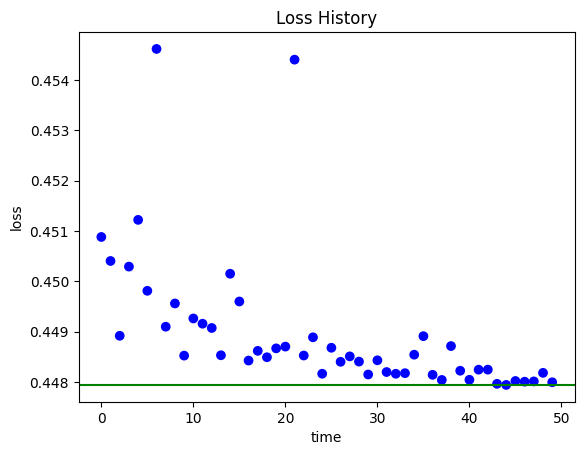

In [56]:
from hyperopt import plotting

plotting.main_plot_history(trials)

The current progress looks promising.  The early trials show a sizable amount of variance in the best score of each trial, but it eventually converges on a consistent loss score.  To continue the trial, just call the trials object again.  This will take a while, even with GPU hardware.

In [ ]:
from hyperopt import fmin

best_param = fmin(objective_function, space="annotated", algo=atpe.suggest, max_evals=150, trials=trials)

In [103]:
model_3_score = pd.Series([-result['result']['loss'] for result in trials.trials], name='Model_3')
results['Model_3'] = model_3_score.sort_values(ascending=False).iloc[:5].reset_index(drop=True)

results

,Model_1,Model_2,Model_3
0,-0.462899,-0.462725,-0.447943
1,-0.440686,-0.441139,-0.447965
2,-0.454137,-0.454067,-0.447995
3,-0.436813,-0.437309,-0.448007
4,-0.447590,-0.448640,-0.448013


## Model 4: GPU Optimized Model

The final model will use gpu-optimized parameters to train the model:

In [150]:
wp_model_parameters = {
    'n_estimators': 15000,
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'grow_policy': 'lossguide',
    'sampling_method': 'gradient_based',
    'eval_metric': ['logloss', 'error'],
    'early_stopping_rounds': 400,
    'learning_rate': 0.5,
    'colsample_bytree': 5 / len(X_train.columns),
    'max_depth': 5,
    'min_child_weight': 7,
    'max_bin': len(groups_train),
    'max_leaves': 2 ** 5,
    'num_parallel_tree': 5,
}

opt_cal_data = make_model_mutations(source_cal_data)
opt_cal_data = prepare_wp_data(opt_cal_data)
opt_cal_data = add_label_column(opt_cal_data)
opt_cal_data = drop_rows(opt_cal_data)
opt_cal_data = opt_cal_data.loc[opt_cal_data['Winner'] != 'TIE']

OPT_CAL_DATA_COLS = ['game_id', 'label', 'receive_2h_ko', 'spread_time', 'home', 'half_seconds_remaining', 'game_seconds_remaining', 'Diff_Time_Ratio', 'score_differential', 'down', 'ydstogo', 'yardline_100', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'season', 'qtr']

opt_cal_data = opt_cal_data[OPT_CAL_DATA_COLS]

X = opt_cal_data.loc[:, ~opt_cal_data.columns.isin(['season', 'game_id', 'label'])]
y = opt_cal_data['label']
groups = opt_cal_data['game_id']

# custom train_test_split that uses GroupKFold to preserve pbp data for each game
X_train, y_train, X_test, y_test = train_test_split(X, y, groups, 5)

groups_train = get_groups_by_index(X_train, groups)
groups_test = get_groups_by_index(X_test, groups)

model_4_clf = xgb.XGBClassifier(**wp_model_parameters)

# Eval against test data to prevent overfitting
fit_params = {
    # 'eval_set': [(X_train, y_train), (X_test, y_test)], 
    'eval_set': [(X_test, y_test)], 
    'verbose': 100
}

model_4_scores = cross_val_score(model_4_clf, X_train, y_train, cv=5, groups=groups_train, fit_params=fit_params, scoring='neg_log_loss')

[0]	validation_0-logloss:0.60683	validation_0-error:0.25901
[100]	validation_0-logloss:0.45743	validation_0-error:0.22731
[200]	validation_0-logloss:0.45891	validation_0-error:0.22774
[300]	validation_0-logloss:0.46019	validation_0-error:0.22861
[400]	validation_0-logloss:0.46139	validation_0-error:0.22912
[478]	validation_0-logloss:0.46222	validation_0-error:0.22929
[0]	validation_0-logloss:0.60756	validation_0-error:0.25760
[100]	validation_0-logloss:0.45717	validation_0-error:0.22835
[200]	validation_0-logloss:0.45866	validation_0-error:0.22914
[300]	validation_0-logloss:0.45983	validation_0-error:0.22938
[400]	validation_0-logloss:0.46104	validation_0-error:0.23006
[447]	validation_0-logloss:0.46152	validation_0-error:0.23028
[0]	validation_0-logloss:0.60671	validation_0-error:0.25721
[100]	validation_0-logloss:0.45664	validation_0-error:0.22728
[200]	validation_0-logloss:0.45791	validation_0-error:0.22777
[300]	validation_0-logloss:0.45923	validation_0-error:0.22863
[400]	validati

## Model Selection

The results of cross validation of all models are as follows:

In [194]:
results = results[['Model_1', 'Model_2', 'Model_3']]
results = pd.concat([results, pd.Series(model_4_scores, name='Model_4')], axis=1)
results.mean().sort_values()

Model_4   -0.448961
Model_2   -0.448776
Model_1   -0.448425
Model_3   -0.447984
dtype: float64

Based on these data, it is appropriate to further investigate Model 4, as it has the lowest log loss score.  The next step is to train the model on the entire training set and evaluate it against the test set.

## Model Training and Evaluation

The model will be trained with data prior to 2023, and then we'll save the 2023 season to evaluate the model's performance.

In [192]:
train_data = opt_cal_data.loc[opt_cal_data['season'] < 2023]
test_data = opt_cal_data.loc[opt_cal_data['season'] == 2023]

X_train = train_data.loc[:, ~train_data.columns.isin(['season', 'game_id', 'label'])]
y_train = train_data['label']
groups_train = train_data['game_id']

X_test = test_data.loc[:, ~test_data.columns.isin(['season', 'game_id', 'label'])]
y_test = test_data['label']
groups_test = test_data['game_id']

wp_model_parameters = {
    'n_estimators': 15000,
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'grow_policy': 'lossguide',
    'sampling_method': 'gradient_based',
    'eval_metric': 'logloss',
    'early_stopping_rounds': 400,
    'learning_rate': 0.5,
    'colsample_bytree': 5 / len(X_train.columns),
    'max_depth': 5,
    'min_child_weight': 7,
    'max_bin': len(groups_train),
    'max_leaves': 2 ** 5,
    'num_parallel_tree': 5,
}

train_clf = xgb.XGBClassifier(**wp_model_parameters)

train_clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=100)

[0]	validation_0-logloss:0.60544
[100]	validation_0-logloss:0.43835
[200]	validation_0-logloss:0.43326
[300]	validation_0-logloss:0.42970
[400]	validation_0-logloss:0.42637
[500]	validation_0-logloss:0.42345
[600]	validation_0-logloss:0.42066
[700]	validation_0-logloss:0.41797
[800]	validation_0-logloss:0.41552
[900]	validation_0-logloss:0.41340
[1000]	validation_0-logloss:0.41142
[1100]	validation_0-logloss:0.40953
[1200]	validation_0-logloss:0.40721
[1300]	validation_0-logloss:0.40563
[1400]	validation_0-logloss:0.40359
[1500]	validation_0-logloss:0.40180
[1600]	validation_0-logloss:0.40015
[1700]	validation_0-logloss:0.39871
[1800]	validation_0-logloss:0.39704
[1900]	validation_0-logloss:0.39541
[2000]	validation_0-logloss:0.39398
[2100]	validation_0-logloss:0.39255
[2200]	validation_0-logloss:0.39131
[2300]	validation_0-logloss:0.39008
[2400]	validation_0-logloss:0.38876
[2500]	validation_0-logloss:0.38742


KeyboardInterrupt: 

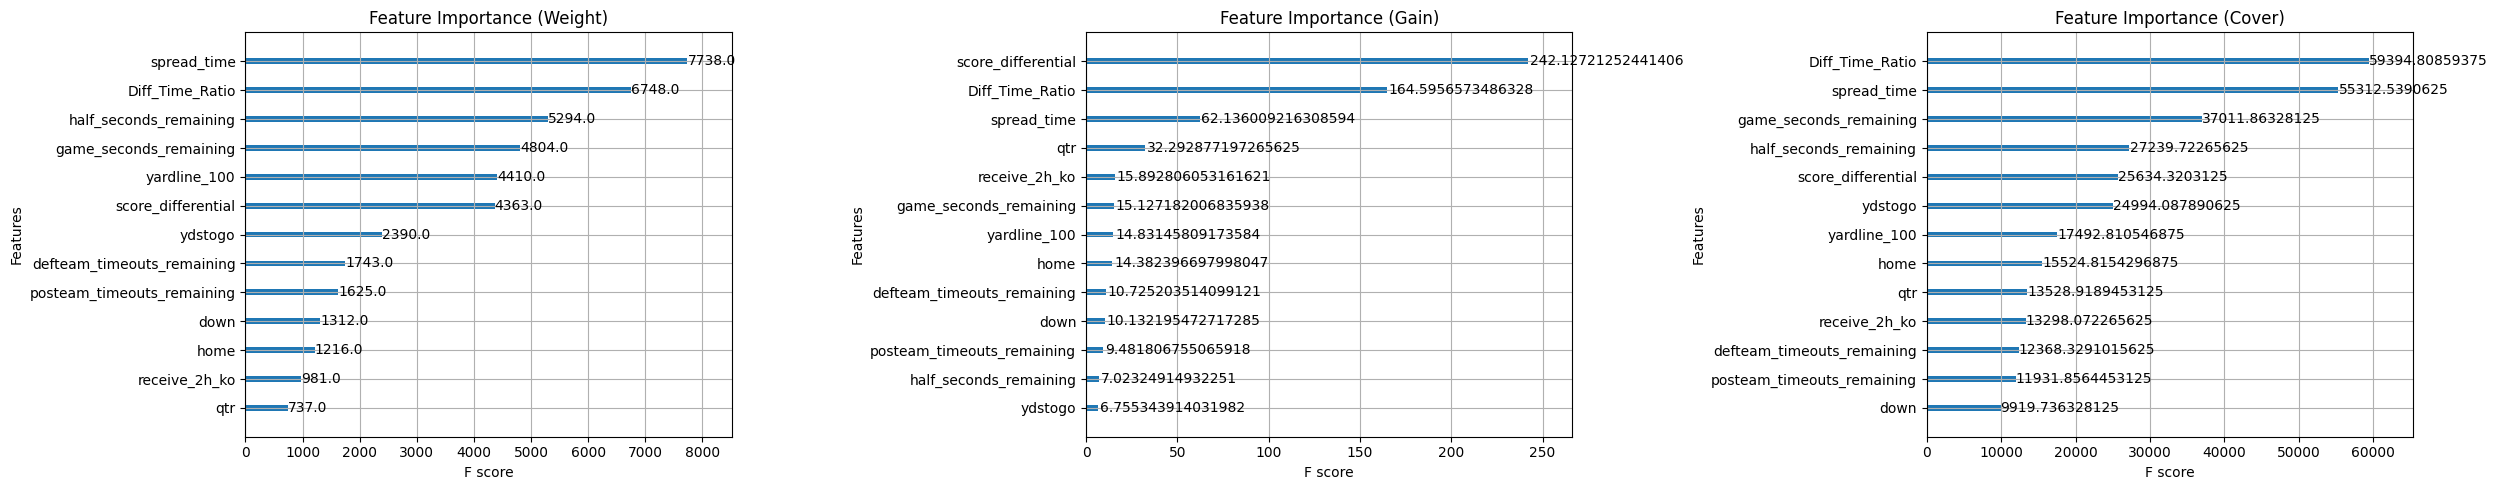

In [187]:
from matplotlib import pyplot as plt

xgb_plot = xgb.plot_importance

fig, ax = plt.subplots(1, 3, figsize=(25, 5))

xgb_plot(model_4_clf, importance_type='weight', ax=ax[0], title='Feature Importance (Weight)')
xgb_plot(model_4_clf, importance_type='gain', ax=ax[1], title='Feature Importance (Gain)')
xgb_plot(model_4_clf, importance_type='cover', ax=ax[2], title='Feature Importance (Cover)')

plt.tight_layout()

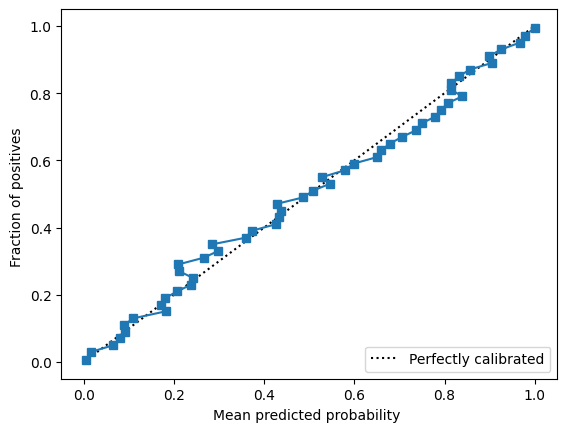

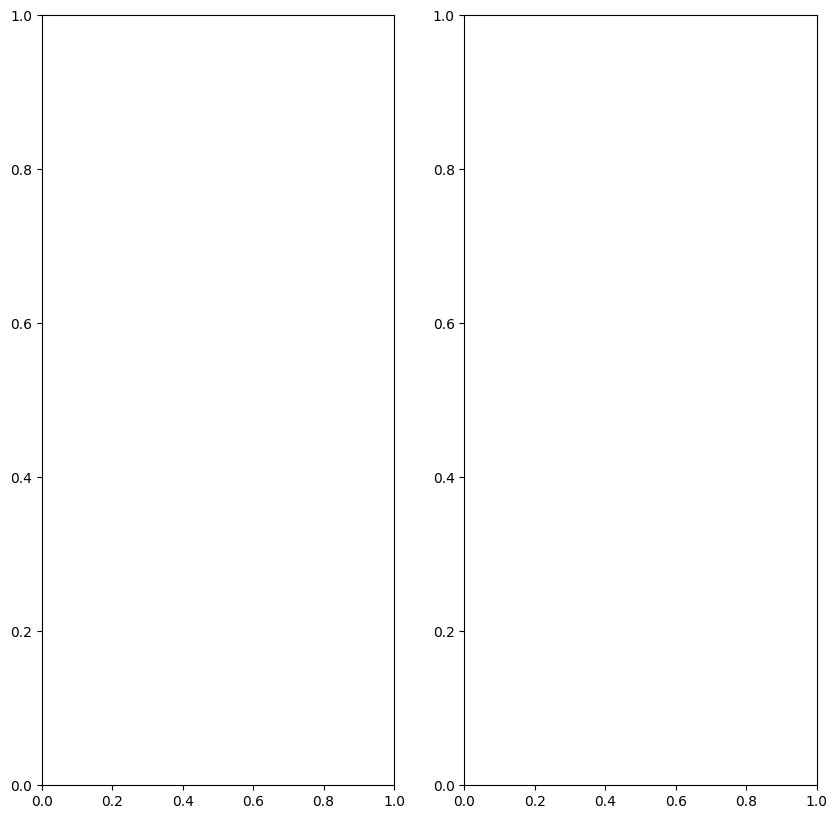

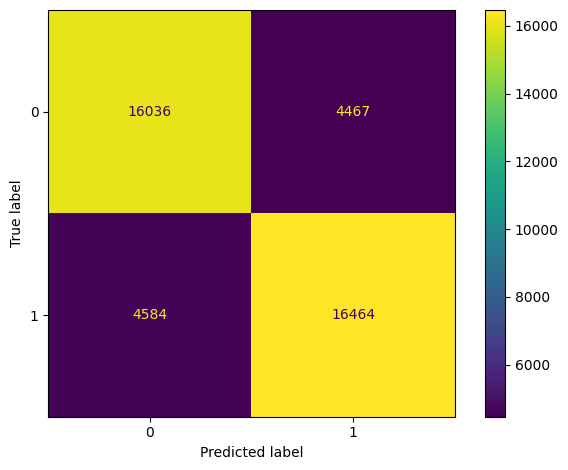

In [189]:
from utils.calibration import plot_calibration_curve, plot_confusion_matrix

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

plt.sca(ax[0])
plot_calibration_curve(model_4_clf, X_test, y_test)

plt.sca(ax[1])
plot_confusion_matrix(model_4_clf, X_test, y_test)

plt.tight_layout()

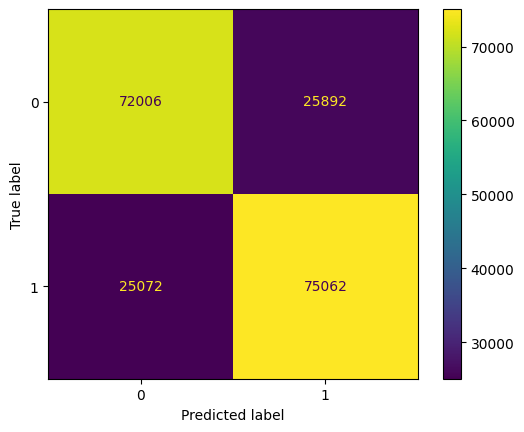

In [89]:
from utils.calibration import plot_confusion_matrix

plot_confusion_matrix(model_4_clf, X_test, y_test)

In [91]:
import pandas as pd

X_test = X_test[['receive_2h_ko', 'spread_time', 'home', 'half_seconds_remaining',
       'game_seconds_remaining', 'Diff_Time_Ratio', 'score_differential',
       'down', 'ydstogo', 'yardline_100', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'qtr']]
preds = model_4_clf.predict(X_test.to_numpy(), validate_features=True)
prob_pred = model_4_clf.predict_proba(X_test.to_numpy(), validate_features=True)[:, 1]
test_df = pd.concat([groups_test, y_test, X_test], axis=1)
test_df['wp'] = prob_pred
test_df['pred'] = preds
test_df

,game_id,label,receive_2h_ko,spread_time,home,half_seconds_remaining,game_seconds_remaining,Diff_Time_Ratio,score_differential,down,ydstogo,yardline_100,posteam_timeouts_remaining,defteam_timeouts_remaining,qtr,wp,pred
1506,1999_01_MIN_ATL,0,0,-4.000000,1,1800.0,3600.0,0.000000,0.0,1.0,10.0,81.0,3.0,3.0,1.0,0.208785,0
1507,1999_01_MIN_ATL,0,0,-4.000000,1,1800.0,3600.0,0.000000,0.0,2.0,7.0,78.0,3.0,3.0,1.0,0.217575,0
1508,1999_01_MIN_ATL,0,0,-4.000000,1,1800.0,3600.0,0.000000,0.0,3.0,7.0,78.0,3.0,3.0,1.0,0.117936,0
1509,1999_01_MIN_ATL,0,0,-4.000000,1,1800.0,3600.0,0.000000,0.0,4.0,2.0,73.0,3.0,3.0,1.0,0.141521,0
1510,1999_01_MIN_ATL,1,1,3.551626,0,1693.0,3493.0,0.000000,0.0,1.0,10.0,76.0,3.0,3.0,1.0,0.429284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197992,2023_21_DET_SF,1,0,0.146024,1,55.0,55.0,154.084504,3.0,1.0,10.0,44.0,1.0,2.0,4.0,0.999789,1
1197994,2023_21_DET_SF,1,0,0.145376,1,51.0,51.0,154.770848,3.0,2.0,8.0,42.0,1.0,1.0,4.0,0.999874,1
1197996,2023_21_DET_SF,1,0,0.144732,1,47.0,47.0,155.460249,3.0,3.0,6.0,40.0,1.0,0.0,4.0,0.996154,1
1197997,2023_21_DET_SF,1,0,0.137520,1,1.0,1.0,163.612557,3.0,4.0,6.0,40.0,1.0,0.0,4.0,0.999524,1


In [100]:
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss, accuracy_score, classification_report, recall_score, precision_score, f1_score, jaccard_score

scores = model_4_clf.evals_result()
pred_accuracy = np.where(test_df['label'] == test_df['pred'], 1, 0).mean()
prob_accuracy = np.where((test_df['wp'] > 0.5) & (test_df['label'] == 1), 1, 0).mean()

models_evals = pd.DataFrame.from_dict(scores['validation_0']).mean()
models_evals['logloss'] = model_4_clf.best_score
models_evals.name = 'Model 1'
models_evals['best_iteration'] = model_4_clf.best_iteration
models_evals['pred_accuracy'] = pred_accuracy
models_evals['prob_accuracy'] = prob_accuracy
models_evals['accuracy'] = accuracy_score(test_df['label'], test_df['pred'])
models_evals['recall'] = recall_score(test_df['label'], test_df['pred'])
models_evals['precision'] = precision_score(test_df['label'], test_df['pred'])
models_evals['f1'] = f1_score(test_df['label'], test_df['pred'])
models_evals['brier'] = brier_score_loss(test_df['label'], test_df['wp'])
models_evals['jaccard'] = jaccard_score(test_df['label'], test_df['pred'])
models_evals['roc_auc'] = roc_auc_score(test_df['label'], test_df['pred'])


# print("Log Loss: " + str(round(sum(scores['validation_0']['logloss']) / len(scores['validation_0']['logloss']), 4)))
# print("Error: " + str(round(sum(scores['validation_0']['error']) / len(scores['validation_0']['error']), 4)))
# print("Area Under Curve: " + str(round(sum(scores['validation_0']['auc']) / len(scores['validation_0']['auc']), 4)))
# print("Prediction Accuracy: " + str(round(pred_accuracy, 4)))
# print("Probability Accuracy: " + str(round(prob_accuracy, 4)))
# print("Accuracy Score: " + str(round(accuracy_score(test_df['label'], test_df['pred']), 4)))
# print("Recall Score: " + str(round(recall_score(test_df['label'], test_df['pred']), 4)))
# print("Precision Score: " + str(round(precision_score(test_df['label'], test_df['pred']), 4)))
# print("F1 Score: " + str(round(f1_score(test_df['label'], test_df['pred']), 4)))
# print("Brier Score: " + str(round(brier, 4)))
# print("Jaccard Score: " + str(round(jaccard_score(test_df['label'], test_df['pred']), 4)))
# print("\n\n")

models_evals
# print(classification_report(test_df['label'], test_df['pred']))

logloss               0.261644
best_iteration    14999.000000
pred_accuracy         0.742648
prob_accuracy         0.379040
accuracy              0.742648
recall                0.749616
precision             0.743527
f1                    0.746559
brier                 0.175295
jaccard               0.595607
roc_auc               0.742568
Name: Model 1, dtype: float64

# Model Training and Evaluation

In [263]:
best_param['max_depth'] = int(best_param['max_depth'])
train_clf = xgb.XGBClassifier(**best_param)
train_clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=100)

[0]	validation_0-logloss:0.50650
[99]	validation_0-logloss:0.44710


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6651808379515829, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=16.422455448232398,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.015091868583711,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=44.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

(<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f28b4455c30>)

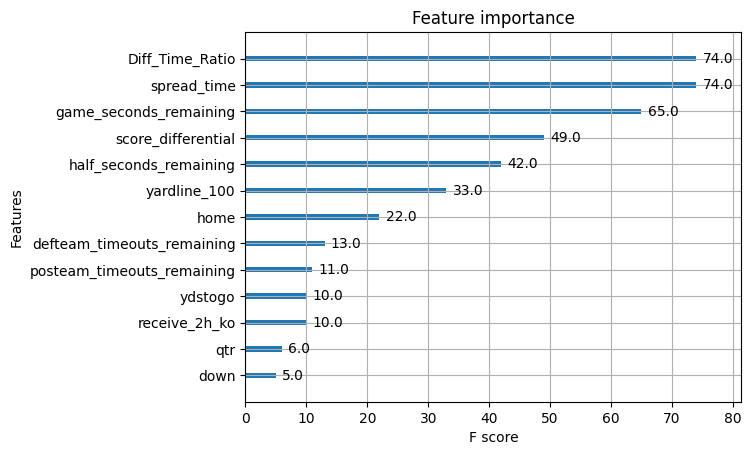

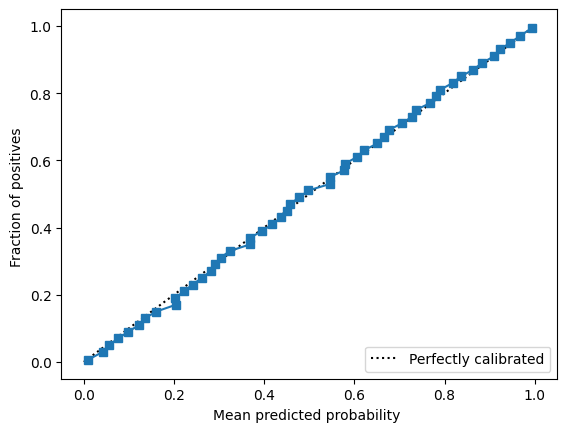

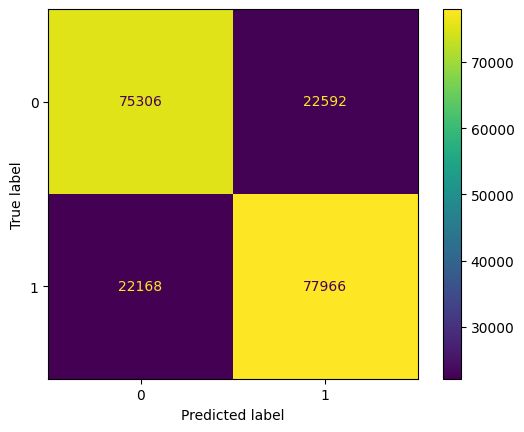

In [265]:
from utils.calibration import plot_feature_importance, plot_calibration_curve, plot_confusion_matrix
plot_feature_importance(train_clf), plot_calibration_curve(train_clf, X_test, y_test), plot_confusion_matrix(train_clf, X_test, y_test)

In [213]:
preds = train_clf.predict(X_test.to_numpy(), validate_features=True)
prob_pred = train_clf.predict_proba(X_test.to_numpy(), validate_features=True)[:, 1]
test_df = pd.concat([groups_test, y_test, X_test], axis=1)
test_df['wp'] = prob_pred
test_df['pred'] = preds

## Model Results

Here we discuss the results of the model training and comparison. Key performance metrics are highlighted, and insights from the model's predictions are drawn.

In [270]:
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss, accuracy_score, classification_report, recall_score, precision_score, f1_score, jaccard_score

scores = train_clf.evals_result()
pred_accuracy = np.where(test_df['label'] == test_df['pred'], 1, 0).mean()
prob_accuracy = np.where(test_df['wp'] > 0.5, 1, 0).mean()
brier = brier_score_loss(test_df['label'], test_df['wp'])

models_evals = pd.DataFrame.from_dict(scores['validation_0']).mean()
models_evals.name = 'Model 1'
models_evals['pred_accuracy'] = pred_accuracy
models_evals['prob_accuracy'] = prob_accuracy
models_evals['accuracy'] = accuracy_score(test_df['label'], test_df['pred'])
models_evals['recall'] = recall_score(test_df['label'], test_df['pred'])
models_evals['precision'] = precision_score(test_df['label'], test_df['pred'])
models_evals['f1'] = f1_score(test_df['label'], test_df['pred'])
models_evals['brier'] = brier_score_loss(test_df['label'], test_df['wp'])
models_evals['jaccard'] = jaccard_score(test_df['label'], test_df['pred'])
models_evals['roc_auc'] = roc_auc_score(test_df['label'], test_df['pred'])

models_evals

logloss          0.448875
pred_accuracy    0.775774
prob_accuracy    0.505555
accuracy         0.775774
recall           0.778187
precision        0.778327
f1               0.778257
brier            0.149250
jaccard          0.637006
roc_auc          0.775746
Name: Model 1, dtype: float64

Compared to the original author's model, which achieved a log loss of approximately 0.44787 to 0.44826, the first model in your EDA had a slightly higher log loss. A lower log loss indicates better predictive accuracy, so in this comparison, the original author's model performed better in terms of log loss. The other metrics (error and AUC) are not directly comparable unless the same metrics are provided for the original model.

## Model Results

In [88]:
models_evals

,Model 1,Model 2,Model 3,Model 4
logloss,0.456013,0.456338,0.457966,0.458133
auc,0.865052,0.865173,0.864755,0.864655
error,0.224923,0.224501,0.224916,0.224960


## Conclusion

This exploratory analysis serves as a preliminary step towards creating a robust and reliable NFL win probability model. The adaptation from R to Python and the transition to the Scikit-Learn API interface of XGBoost demonstrates the flexibility and potential of the model in different environments.

The models tested showed varying levels of performance. The original author's model achieved a log loss of 0.44787 without a monotone constraint on spread_time and 0.44826 with it. Comparatively, your models demonstrated log loss scores of 0.4775, 0.459, 0.4594, and 0.4462 in different configurations and training strategies. These results suggest that your models, particularly the one yielding a log loss of 0.4462, performed comparably and in some cases slightly better than the original author's model. This indicates a successful adaptation and implementation of the methodology in Python, with potential for further optimization and refinement.
 
## References

1. Sebastian Carl, & Ron Yurko. (2021). Creating a Model from Scratch Using XGBoost in R. Open Source Football. https://opensourcefootball.com/posts/2021-04-13-creating-a-model-from-scratch-using-xgboost-in-r/#model-evaluation
2. Benjamin Robinson, & Sebastian Carl. (2020). NFLfastr: EP, WP, and CP Models. Open Source Football. https://opensourcefootball.com/posts/2020-09-28-nflfastr-ep-wp-and-cp-models/
3. nflverse Project. https://nflverse.nflverse.com/